# Importando Bibliotecas

In [1]:
# Pytorch
import torch, os, datetime, torchvision
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms 
from torchvision.utils import make_grid

#Plot
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns

# Processamento
import numpy as np
import random
import pandas as pd
import time
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler

Definindo uma seed padrão, para manter uma constância nos resultados, caso seja necessário rodar o projeto novamente

In [2]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Selecionando o dispositivo para rodar o projeto (Prefencialmente GPU)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Carregando e Processando os Dados

Iremos trabalhar com o valor de fechamento do BTC no dia, então iremos remover o valor de abertura do dataset

In [4]:
dataset = pd.read_csv('../data/Bitstamp_BTCUSD_d.csv')

In [5]:
dataset['date'] = pd.to_datetime(dataset['date'])

# Converte a data para colunas de valores numéricos ['Day', 'Month', 'Year']
dataset['day'] = dataset['date'].dt.day
dataset['month'] = dataset['date'].dt.month
dataset['year'] = dataset['date'].dt.year

dataset

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD,day,month,year
0,1717459200,2024-06-04,BTC/USD,68798.00,68868.00,68792.00,68857.00,6.283420e-01,4.326574e+04,4,6,2024
1,1717372800,2024-06-03,BTC/USD,67744.00,70268.00,67590.00,68801.00,2.391376e+03,1.645291e+08,3,6,2024
2,1717286400,2024-06-02,BTC/USD,67722.00,68405.00,67281.00,67752.00,5.443606e+02,3.688152e+07,2,6,2024
3,1717200000,2024-06-01,BTC/USD,67513.00,67810.00,67387.00,67723.00,3.686240e+02,2.496433e+07,1,6,2024
4,1717113600,2024-05-31,BTC/USD,68330.00,69010.00,66624.00,67477.00,1.880059e+03,1.268607e+08,31,5,2024
...,...,...,...,...,...,...,...,...,...,...,...,...
3472,1417478400,2014-12-02,BTC/USD,378.39,382.86,375.23,379.25,2.593576e+06,6.832530e+03,2,12,2014
3473,1417392000,2014-12-01,BTC/USD,376.40,382.31,373.03,378.39,2.520662e+06,6.660560e+03,1,12,2014
3474,1417305600,2014-11-30,BTC/USD,376.57,381.99,373.32,373.34,1.145567e+06,3.046330e+03,30,11,2014
3475,1417219200,2014-11-29,BTC/USD,376.42,386.60,372.25,376.72,2.746157e+06,7.245190e+03,29,11,2014


Podemos verificar que a coluna 'symbol' apenas um único valor para todas as instâncias, por isso vamor removê-la

In [6]:
dataset['symbol'].describe()

count        3477
unique          1
top       BTC/USD
freq         3477
Name: symbol, dtype: object

In [7]:
dataset.drop(['symbol'], axis=1, inplace=True)

Agora iremos configurar a coluna de data para ser o index do dataset. Além disso, iremos remover instâncias que possuem alguma coluna com valor NA ou que sejam duplicatas.

In [8]:
# Configura a coluna de data como index do Dataframe
dataset.set_index('date', inplace=True, drop=False)
dataset = dataset.reset_index(drop=True)

# Verificar e remover valores nulos
dataset = dataset.dropna()

# Verificar e remover duplicatas
dataset = dataset.drop_duplicates()

In [9]:
dataset

,unix,date,open,high,low,close,Volume BTC,Volume USD,day,month,year
0,1717459200,2024-06-04,68798.00,68868.00,68792.00,68857.00,6.283420e-01,4.326574e+04,4,6,2024
1,1717372800,2024-06-03,67744.00,70268.00,67590.00,68801.00,2.391376e+03,1.645291e+08,3,6,2024
2,1717286400,2024-06-02,67722.00,68405.00,67281.00,67752.00,5.443606e+02,3.688152e+07,2,6,2024
3,1717200000,2024-06-01,67513.00,67810.00,67387.00,67723.00,3.686240e+02,2.496433e+07,1,6,2024
4,1717113600,2024-05-31,68330.00,69010.00,66624.00,67477.00,1.880059e+03,1.268607e+08,31,5,2024
...,...,...,...,...,...,...,...,...,...,...,...
3472,1417478400,2014-12-02,378.39,382.86,375.23,379.25,2.593576e+06,6.832530e+03,2,12,2014
3473,1417392000,2014-12-01,376.40,382.31,373.03,378.39,2.520662e+06,6.660560e+03,1,12,2014
3474,1417305600,2014-11-30,376.57,381.99,373.32,373.34,1.145567e+06,3.046330e+03,30,11,2014
3475,1417219200,2014-11-29,376.42,386.60,372.25,376.72,2.746157e+06,7.245190e+03,29,11,2014


In [10]:
# Normaliza os dados
scaler = StandardScaler()
dataset[['unix', 'high', 'low', 'open', 'Volume BTC', 'Volume USD', 'day', 'month', 'year']] = scaler.fit_transform(dataset[['unix', 'high', 'low', 'open', 'Volume BTC', 'Volume USD', 'day', 'month', 'year']], dataset['close'])


# Análise Exploratória

In [11]:
dataset

,unix,date,open,high,low,close,Volume BTC,Volume USD,day,month,year
0,1.731553,2024-06-04,2.827719,2.741004,2.932841,68857.00,-0.244056,-0.641148,-1.330763,-0.120977,1.746021
1,1.730556,2024-06-03,2.770379,2.815338,2.865611,68801.00,-0.243998,1.035556,-1.444246,-0.120977,1.746021
2,1.729560,2024-06-02,2.769182,2.716421,2.848328,67752.00,-0.244043,-0.265633,-1.557730,-0.120977,1.746021
3,1.728564,2024-06-01,2.757812,2.684829,2.854256,67723.00,-0.244047,-0.387112,-1.671213,-0.120977,1.746021
4,1.727568,2024-05-31,2.802259,2.748544,2.811580,67477.00,-0.244011,0.651580,1.733291,-0.407904,1.746021
...,...,...,...,...,...,...,...,...,...,...,...
3472,-1.727568,2014-12-02,-0.894483,-0.895248,-0.893868,379.25,-0.181640,-0.641519,-1.557730,1.600587,-1.872573
3473,-1.728564,2014-12-01,-0.894592,-0.895278,-0.893991,378.39,-0.183394,-0.641521,-1.671213,1.600587,-1.872573
3474,-1.729560,2014-11-30,-0.894582,-0.895295,-0.893975,373.34,-0.216487,-0.641558,1.619808,1.313660,-1.872573
3475,-1.730556,2014-11-29,-0.894591,-0.895050,-0.894035,376.72,-0.177968,-0.641515,1.506324,1.313660,-1.872573


In [12]:
num_linhas = int(len(dataset) * 0.2) # Pegando 20% do dataset

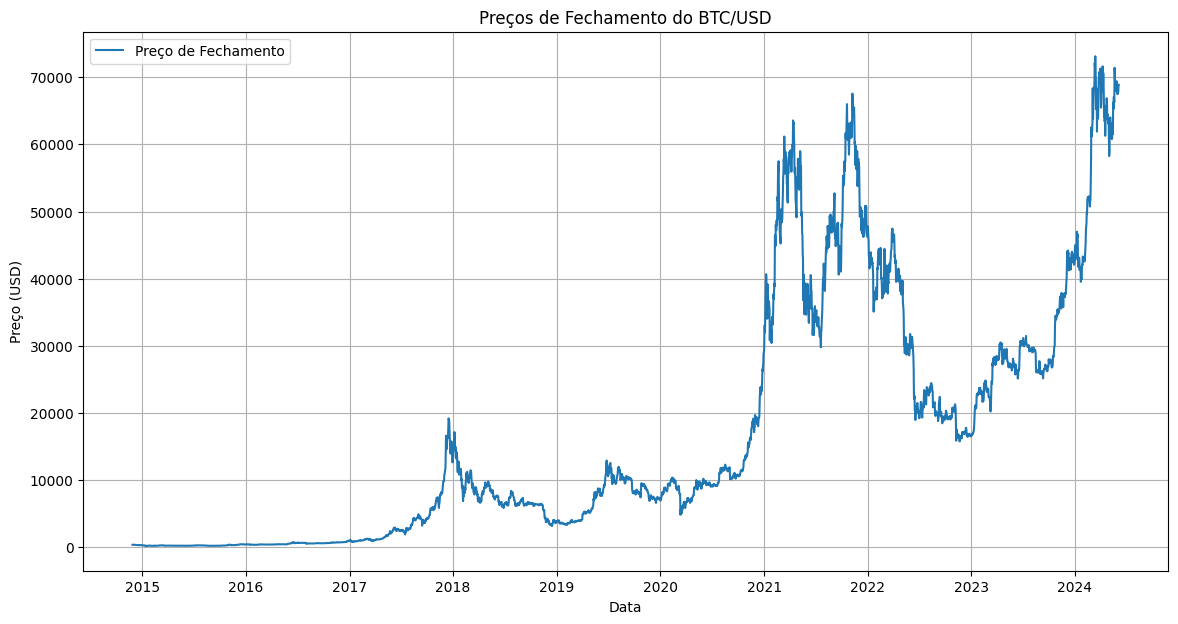

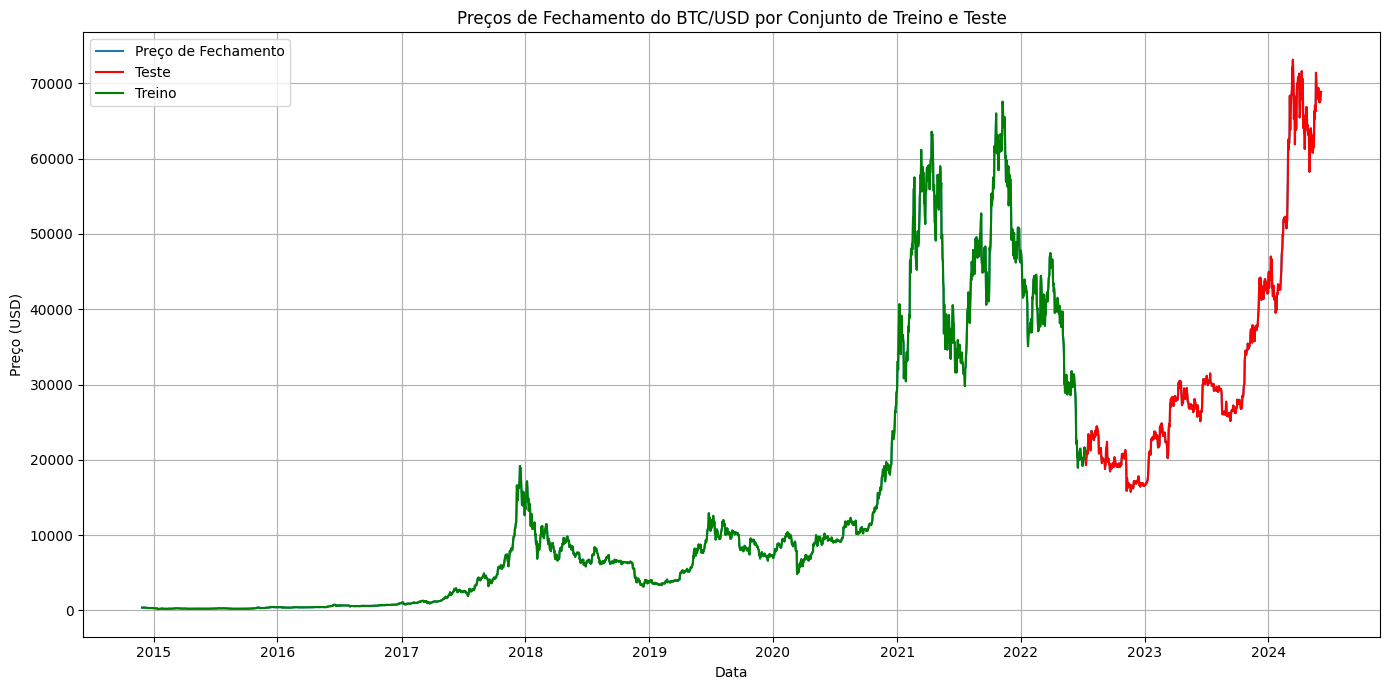

In [13]:
# Plotar os preços de fechamento ao longo do tempo
plt.figure(figsize=(14, 7))
plt.plot(dataset['date'], dataset['close'], label='Preço de Fechamento')
plt.title('Preços de Fechamento do BTC/USD')
plt.xlabel('Data')
plt.ylabel('Preço (USD)')
plt.legend()
plt.grid(True)

# Plotar os preços de fechamento do conjunto de treino e teste
plt.figure(figsize=(14, 7))
plt.plot(dataset['date'], dataset['close'], label='Preço de Fechamento')
plt.plot(dataset.iloc[:num_linhas]['date'], dataset.iloc[:num_linhas]['close'], label='Teste', color='red')
plt.plot(dataset.iloc[num_linhas:]['date'], dataset.iloc[num_linhas:]['close'], label='Treino', color='green')
plt.title('Preços de Fechamento do BTC/USD por Conjunto de Treino e Teste')
plt.xlabel('Data')
plt.ylabel('Preço (USD)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

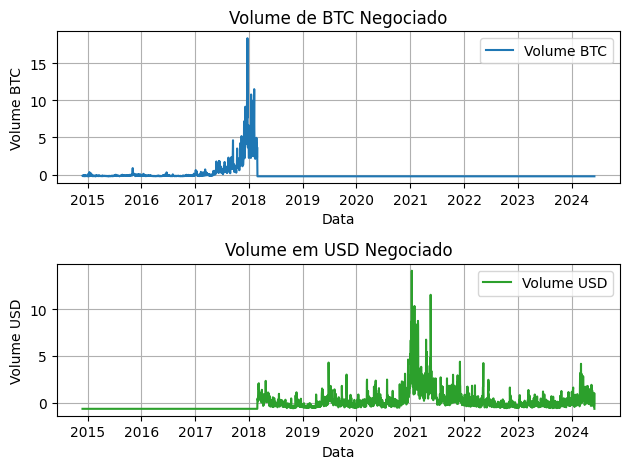

In [14]:
plt.subplot(2, 1, 1)
plt.plot(dataset['date'], dataset['Volume BTC'], label='Volume BTC', color='tab:blue')
plt.title('Volume de BTC Negociado')
plt.xlabel('Data')
plt.ylabel('Volume BTC')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(dataset['date'], dataset['Volume USD'], label='Volume USD', color='tab:green')
plt.title('Volume em USD Negociado')
plt.xlabel('Data')
plt.ylabel('Volume USD')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

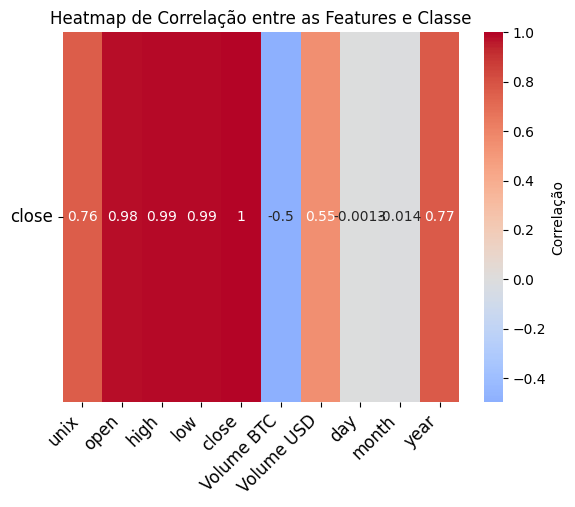

In [15]:
# Calcular a correlação entre preço e volume
correlation = dataset.corr(method='kendall', numeric_only=True)

sns.heatmap(correlation[['close']].T, annot=True, cmap='coolwarm', center=0, cbar_kws={'label': 'Correlação'})
plt.title('Heatmap de Correlação entre as Features e Classe')
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.show()

# Divisão dos Dados

In [16]:
num_linhas = int(len(dataset) * 0.2) # Pegando 20% do dataset

test = dataset.iloc[:num_linhas]
treino = dataset.iloc[num_linhas:]

#Invertendo os datasets
test = test.iloc[::-1].reset_index(drop=True)
treino = treino.iloc[::-1].reset_index(drop=True)

In [17]:
num_linhas = int(len(dataset) * 0.2) # Pegando 20% do dataset

test = dataset.iloc[:num_linhas]
treino = dataset.iloc[num_linhas:]

#Invertendo os datasets
test = test.iloc[::-1].reset_index(drop=True)
treino = treino.iloc[::-1].reset_index(drop=True)

In [18]:
print(f"Tamanho Dataset: {len(dataset)}\nTamanho conjunto de Treinamento: {len(treino)}\nTamanho Conjunto de Teste: {len(test)}")

Tamanho Dataset: 3477
Tamanho conjunto de Treinamento: 2782
Tamanho Conjunto de Teste: 695


In [19]:
test

,unix,date,open,high,low,close,Volume BTC,Volume USD,day,month,year
0,1.040127,2022-07-11,0.219287,0.191929,0.196464,19949.71,-0.244023,-0.360742,-0.536378,0.165951,1.022302
1,1.041123,2022-07-12,0.170184,0.148258,0.161138,19321.14,-0.244014,-0.299280,-0.422895,0.165951,1.022302
2,1.042120,2022-07-13,0.136963,0.165866,0.142576,20232.35,-0.243979,0.017734,-0.309411,0.165951,1.022302
3,1.043116,2022-07-14,0.185236,0.193057,0.181892,20577.23,-0.243994,-0.101517,-0.195928,0.165951,1.022302
4,1.044112,2022-07-15,0.203947,0.209323,0.224413,20835.39,-0.244018,-0.305627,-0.082444,0.165951,1.022302
...,...,...,...,...,...,...,...,...,...,...,...
690,1.727568,2024-05-31,2.802259,2.748544,2.811580,67477.00,-0.244011,0.651580,1.733291,-0.407904,1.746021
691,1.728564,2024-06-01,2.757812,2.684829,2.854256,67723.00,-0.244047,-0.387112,-1.671213,-0.120977,1.746021
692,1.729560,2024-06-02,2.769182,2.716421,2.848328,67752.00,-0.244043,-0.265633,-1.557730,-0.120977,1.746021
693,1.730556,2024-06-03,2.770379,2.815338,2.865611,68801.00,-0.243998,1.035556,-1.444246,-0.120977,1.746021


In [20]:
treino

,unix,date,open,high,low,close,Volume BTC,Volume USD,day,month,year
0,-1.731553,2014-11-28,-0.895289,-0.895329,-0.894688,376.28,-0.166543,-0.641501,1.392841,1.313660,-1.872573
1,-1.730556,2014-11-29,-0.894591,-0.895050,-0.894035,376.72,-0.177968,-0.641515,1.506324,1.313660,-1.872573
2,-1.729560,2014-11-30,-0.894582,-0.895295,-0.893975,373.34,-0.216487,-0.641558,1.619808,1.313660,-1.872573
3,-1.728564,2014-12-01,-0.894592,-0.895278,-0.893991,378.39,-0.183394,-0.641521,-1.671213,1.600587,-1.872573
4,-1.727568,2014-12-02,-0.894483,-0.895248,-0.893868,379.25,-0.181640,-0.641519,-1.557730,1.600587,-1.872573
...,...,...,...,...,...,...,...,...,...,...,...
2777,1.035146,2022-07-06,0.181940,0.180780,0.189817,20547.45,-0.244006,-0.203125,-1.103796,0.165951,1.022302
2778,1.036142,2022-07-07,0.202702,0.244414,0.217079,21643.56,-0.243974,0.113519,-0.990312,0.165951,1.022302
2779,1.037138,2022-07-08,0.261161,0.273816,0.268900,21584.14,-0.243975,0.096127,-0.876829,0.165951,1.022302
2780,1.038135,2022-07-09,0.259629,0.250145,0.277138,21588.35,-0.244035,-0.451149,-0.763345,0.165951,1.022302


# Definindo a classe LSTM

In [21]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

# Definindo funções úteis

Criando um DataLoader a partir do DataFrame

In [22]:
class CustomDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

In [23]:
train_features = torch.tensor(treino[['unix', 'high', 'low', 'open', 'Volume BTC', 'Volume USD', 'day', 'month', 'year']].values, dtype=torch.float32)
train_targets = torch.tensor(treino['close'].values, dtype=torch.float32)

test_features = torch.tensor(test[['unix', 'high', 'low', 'open', 'Volume BTC', 'Volume USD', 'day', 'month', 'year']].values, dtype=torch.float32)
test_targets = torch.tensor(test['close'].values, dtype=torch.float32)

In [24]:
train_data = CustomDataset(train_features, train_targets)
trainloader = DataLoader(train_data, batch_size=2, shuffle=True)

test_data = CustomDataset(test_features, test_targets)
testloader = DataLoader(test_data, batch_size=2, shuffle=True)

Função de Treinamento

In [25]:
def train_model(model, criterion, optimizer, epochs):
    model.train().to(device)

    for epoch in range(epochs):
        running_loss = 0.0

        for inputs, labels in trainloader:
            labels = labels.view(-1, 1)
            (inputs, labels) = (inputs.to(device), labels.to(device))
            optimizer.zero_grad()
            outputs = model(inputs)

            # print(f"OUTPUT:\n{outputs}\nLABELS:\n{labels}\n\n--------------------------------------------------------------\n")
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}')
    
    print('Finished Training!')

Função de Teste do Modelo

In [26]:
def test_model(model, criterion):
    model.eval().to(device)
    correct = 0
    total = 0
    test_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in testloader:
            labels = labels.view(-1, 1)
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # print(f"OUTPUT:\n{outputs}\nLABELS:\n{labels}\n\n--------------------------------------------------------------\n")

            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # accuracy = correct / total
    loss = test_loss / len(testloader)
    # precision = precision_score(all_labels, all_predictions, average='weighted')
    # recall = recall_score(all_labels, all_predictions, average='weighted')
    # f1 = f1_score(all_labels, all_predictions, average='weighted')

    # return accuracy, loss, precision, recall, f1
    print(f"Loss: {loss}")
    return loss

# Treinando o Modelo

In [27]:
input_size = 9
hidden_size = 2
n_layers = 1
dropout_rate = 0

In [28]:
model = LSTM(
    input_size,
    hidden_size,
    n_layers,
)

In [29]:
n_epochs = 2
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_func = nn.MSELoss().to(device)

In [30]:
train_model(
    model,
    loss_func,
    optimizer,
    n_epochs
)

Epoch 1, Loss: 440242756.245094
Epoch 2, Loss: 440163577.7794387
Finished Training!


# Testando o Modelo

In [31]:
loss = test_model(
    model,
    loss_func
)

Loss: 1349009321.5632184
